In [1]:
from pathlib import Path
from asim.dataset.scene.arrow_scene import ArrowScene

In [2]:
import geopandas as gpd

gpd.__version__

'1.1.0'

Map objects loaded in 0.002423 seconds
Map objects added to ax in 0.110172 seconds


<Axes: title={'center': 'Map: carla_town03'}>

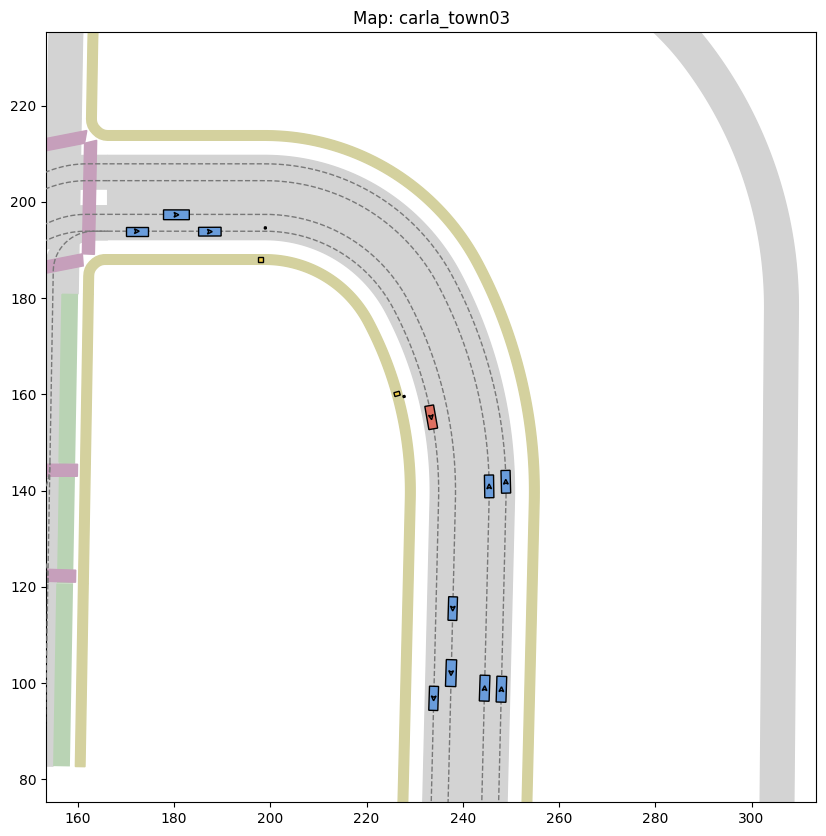

In [10]:
from typing import Optional, Tuple, Union

import matplotlib.pyplot as plt

import numpy as np

from asim.common.geometry.base import Point2D
from asim.common.geometry.bounding_box.bounding_box import BoundingBoxSE2, BoundingBoxSE3
from asim.common.geometry.tranform_2d import translate_along_yaw
from asim.common.visualization.color.color import ELLIS_5
from asim.dataset.scene.abstract_scene import AbstractScene

from asim.common.visualization.matplotlib.map import add_default_map_on_ax
from asim.common.visualization.matplotlib.observation import add_box_detections_to_ax, add_ego_vehicle_to_ax, add_traffic_lights_to_ax



def plot_scene_at_iteration(scene: AbstractScene, iteration: int = 0, ax: Optional[plt.Axes] = None):

    radius = 100

    ego_vehicle_state = scene.get_ego_vehicle_state_at_iteration(iteration)
    box_detections = scene.get_box_detections_at_iteration(iteration)
    traffic_light_detections = scene.get_traffic_light_detections_at_iteration(iteration)
    map_api = scene.map_api

    point_2d = ego_vehicle_state.bounding_box.center.state_se2.point_2d

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    add_default_map_on_ax(ax, map_api, point_2d, radius=radius)
    add_traffic_lights_to_ax(ax, traffic_light_detections, map_api)

    add_box_detections_to_ax(ax, box_detections)
    add_ego_vehicle_to_ax(ax, ego_vehicle_state)

    buffer_radius = 0.8 * radius
    ax.set_xlim(point_2d.x - buffer_radius, point_2d.x + buffer_radius)
    ax.set_ylim(point_2d.y - buffer_radius, point_2d.y + buffer_radius)

    ax.set_aspect("equal", adjustable="box")

    return ax


# log_name = "2021.08.30.14.54.34_veh-40_00439_00835"
# log_file = Path(f"/home/daniel/asim_workspace/data/mini/{log_name}.arrow")
log_name = "_Rep0_longest6_route14_06_09_13_02_18"
log_file = Path(f"/home/daniel/asim_workspace/data/carla/{log_name}.arrow")
scene = ArrowScene(log_file)

plot_scene_at_iteration(scene, iteration=1700)

0.004953 seconds
0.003894

0.002941

In [4]:
from asim.dataset.maps.abstract_map import MapSurfaceType


432 in set(scene.map_api._gpd_dataframes[MapSurfaceType.LANE]["id"])

False

In [5]:
lane = scene.map_api.get_map_object(str(432), MapSurfaceType.LANE)

lane

In [ ]:

import traceback
import matplotlib.animation as animation

import io

from PIL import Image
from tqdm import tqdm
import matplotlib.animation as animation

def create_animation_mp4(scene, output_path, start_idx=0, end_idx=None, step=10, fps=20):
    if end_idx is None:
        end_idx = len(scene._recording_table)
    print(end_idx)

    fig, ax = plt.subplots(figsize=(10, 10))

    def update(i):
        ax.clear()
        plot_scene_at_iteration(scene, i, ax)
        # Adjust border size (white space) around the figure
        plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
        pbar.update(1)

    frames = list(range(start_idx, end_idx, step))
    pbar = tqdm(total=len(frames))
    ani = animation.FuncAnimation(fig, update, frames=frames, repeat=False)

    ani.save(output_path / f"{scene._arrow_log_path.stem}.mp4", writer='ffmpeg', fps=fps, dpi=300)
    plt.close(fig)


# Create an mp4 animation with a specific FPS
output_path = Path("/home/daniel/asim_logs_videos")
log_path = Path("/home/daniel/asim_workspace/data/carla")
for log_file in log_path.iterdir():
    scene = ArrowScene(log_file)
    try:
        create_animation_mp4(scene, output_path, fps=30, end_idx=None, step=5)
    except Exception as e:
        traceback.print_exc()
        erroneous_file = output_path / f"{log_name}.mp4"
        if erroneous_file.exists():
            erroneous_file.unlink()
    del scene



